In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd '/content/gdrive/MyDrive/DEEPLOBE/data'
# Folder structure 
#Folder - Mask , Images

/content/gdrive/MyDrive/DEEPLOBE/data


In [5]:
!pip install pytorch_lightning

     |████████████████████████████████| 819kB 6.0MB/s 
     |████████████████████████████████| 276kB 44.8MB/s 
     |████████████████████████████████| 112kB 51.4MB/s 
     |████████████████████████████████| 829kB 28.9MB/s 
     |████████████████████████████████| 1.3MB 41.2MB/s 
     |████████████████████████████████| 296kB 53.7MB/s 
     |████████████████████████████████| 143kB 55.8MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=dd6432b9420d0342cc127caa8efd3653ce3ed3f2ada00fff89ae556be37b5d39
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=739fd5b8240e09ecf8d7583d930d806a249ed4919193473250c8ed5dcbd7eadf
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
  Found existing installation: PyYAML 3.13
    U

In [ ]:
# from setup import *

In [14]:
from pathlib import Path
import random
from PIL import Image
import torch
import torch.nn.functional as F 
import torch.nn as nn
# To get MNIST data and transforms 
from torchvision import datasets, transforms 
# To get the optimizer for our model 
from torch.utils.data import random_split, DataLoader 
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision.models.segmentation.fcn import FCNHead
from torchvision import models
import torchvision.transforms as T
# Plot the input image, ground truth and the predicted output
from matplotlib import pyplot as plt
from PIL import *
import numpy as np
#!pip install pytorch-lightning
import pytorch_lightning as pl  


def return_files(path):
  files = []
  extensions = ["jpg",'jpeg','png','PNG']
  for ext in extensions:
    files.extend(path.glob('*.'+ext))
  return files


def process_data(loc):
  # Data directory
  #loc = '/content/gdrive/My Drive/DEEPLOBE/data'
  path = Path(loc)
  path_lbl = path/'Masks'
  #path_lbl.to_globa
  path_img = path/'Images'
  mask_definitions = path/'mask_definitions.json'
  img_files = return_files(path_img)
  #mask_files = return_files(path_lbl)
  train_imgs = [img for img in img_files]
  #train_masks = [mask for mask in mask_files]
  with open(mask_definitions) as md:
      mask_def = eval(md.read())
  mask_info = {}
  label_dict = {}
  for image in mask_def['masks']:
      mask=mask_def['masks'][image]['mask']
      mask = mask.lstrip('masks/')
      colors = mask_def['masks'][image]['color_categories']
      rgb = colors.keys()
      categories = [i['super_category'] for i in colors.values()]
      color_map = dict(zip(rgb,categories))
      mask_info.update({mask:color_map})
  for v in mask_info.values():
    label_dict.update(v.items())
  #create an rgb dict with colors as keys and labels as values
  label_dict['(0, 0, 0)'] = 'background'
  name2id = {v:k for k,v in enumerate(sorted(label_dict.values()))}
  class_dict = {eval(v):k for k,v in enumerate(sorted(label_dict.keys()))}
  #classes = len(name2id.keys())
  return class_dict, train_imgs, path_lbl


class CustomDataset():
    def __init__(self,class_dict,path_lbl ,img_files, img_transform=None,mask_transform=None):
        self.class_dict=class_dict
        self.img_files = img_files
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.path_lbl=path_lbl
    #helper function to convert rbg mask to label encoded masks
    def mask_to_class(self,mask):
        target = torch.from_numpy(mask)
        #target = target.permute(1,2,0).contiguous()
        h,w = target.shape[0],target.shape[1]
        masks = torch.zeros(h, w, dtype=torch.long)
        colors = torch.unique(target.view(-1,target.size(2)),dim=0).numpy()
        target = target.permute(2, 0, 1).contiguous()
        mapping = self.class_dict #{tuple(c): t for c, t in zip(colors.tolist(), range(len(colors)))}
        for k in mapping:
            idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
            validx = (idx.sum(0) == 3) 
            masks[validx] = torch.tensor(mapping[k], dtype=torch.long)
        return masks
    def __getitem__(self, idx):
        image_file = self.img_files[idx]
        mask_file = self.path_lbl/image_file.name      
        image = Image.open(image_file)
        mask = Image.open(mask_file)         
        #apply tranforms
        if self.img_transform:
          image = self.img_transform(image)
        if self.mask_transform:
          mask = self.mask_transform(mask)
        #encode RGB mask to class_labels
        mask = np.array(mask)
        mask = self.mask_to_class(mask)
        return image, mask
    def __len__(self):  # return count of sample we have
        return len(self.img_files)


def get_img_transform(train=True):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.Resize(256))
    transforms.append(T.CenterCrop(224))
    transforms.append(T.ToTensor())
    transforms.append(T.Normalize(mean=[0.485,0.456,0.406],
                                std=[0.229,0.224,0.225]))
    return T.Compose(transforms)


def get_mask_transform(train=True):
    transforms = []
    # apply same resize and cropping on masks
    transforms.append(T.Resize(256))
    transforms.append(T.CenterCrop(224))    
    #transforms.append(T.ToTensor())
    return T.Compose(transforms)


class DataModulesemantic(pl.LightningDataModule):
  def __init__(self,class_dict,train_imgs,path_lbl):
    super(DataModulesemantic,self).__init__()
    self.class_dict=class_dict
    self.train_imgs=train_imgs
    self.path_lbl=path_lbl
    self.train_dataset = CustomDataset(self.class_dict,self.path_lbl,self.train_imgs,img_transform=get_img_transform(train=True),mask_transform=get_mask_transform(train=True))
    #self.valid_dataset = CustomDataset(valid_imgs,img_transform=get_img_transform(train=False),mask_transform=get_mask_transform(train=False))
    length=len(self.train_dataset)
    trl,vel,tel= int(length*0.8), int(length*0.1), int(length*0.1)
    self.train_data, self.val_data, self.test_data = random_split(self.train_dataset,[trl,vel,tel])
    self.bs = 1
  def train_dataloader(self):
    return DataLoader(self.train_data,batch_size=self.bs)
  def val_dataloader(self):
    return DataLoader(self.val_data,batch_size=self.bs)
  def test_dataloader(self):
    return DataLoader(self.test_data,batch_size=self.bs)  


class FCNHead_model(pl.LightningModule):
  def __init__(self,model):
    super(FCNHead_model,self).__init__()
    self.model=model
    self.criterion = nn.CrossEntropyLoss()
    self.params = [p for p in self.model.parameters() if p.requires_grad]
    #self.optimizer = torch.optim.Adadelta(params, lr=1e-4)
  def configure_optimizers(self):
    return torch.optim.Adadelta(self.params, lr=1e-4)
  def training_step(self, train_batch, batch_idx):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    x, y = train_batch
    x=x.to(device)
    y=y.to(device) 
    logits = self.model(x) 
    loss = self.criterion(logits['out'], y)
    self.log('Training Loss', loss, on_step=True, on_epoch=True, sync_dist=True) 
    return loss 
  def validation_step(self, valid_batch, batch_idx):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    x, y = valid_batch 
    x=x.to(device)
    y=y.to(device) 
    logits = self.model(x) 
    loss = self.criterion(logits['out'], y)
    self.log('Validation Loss', loss, on_step=True, on_epoch=True, sync_dist=True) 
    return loss
  def test_step(self, test_batch, batch_idx):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    x, y = test_batch 
    x=x.to(device)
    y=y.to(device) 
    logits = self.model(x) 
    loss = self.criterion(logits['out'], y)
    self.log('Testing Loss', loss, on_step=True, on_epoch=True, sync_dist=True) 
    return loss

def predict_img(img,model):
    import matplotlib.pyplot as plt
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    img = Image.open(img).convert('RGB')
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
    t_img = transform(img).unsqueeze(0)
    t_img=t_img.to(device)
    out = model(t_img)
    y_pred_final=out['out']
    pred = y_pred_final.cpu().detach().numpy()
    pred = np.argmax(pred[0], axis = 0)
    print('Image')
    plt.imshow(img)
    plt.show()
    print('Segmentation Output')
    plt.imshow(pred)
    plt.show()
def create_model(classes):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = models.segmentation.fcn_resnet101(pretrained=True)
  model.classifier = FCNHead(2048,len(classes))
  model.aux_classifier = FCNHead(1024,len(classes))
  model.to(device)
  return model
def train_model(epochs,path):
  max_epoc= 10 if epochs is None else epochs
  classes, images, path1 = process_data(path)
  model=create_model(classes)
  data_module = DataModulesemantic(classes,images,path1) 
  model_module = FCNHead_model(model)
  gpu=1 if torch.cuda.is_available() else 0
  trainer = pl.Trainer(max_epochs=max_epoc,gpus=gpu) 
  trainer.fit(model_module, data_module)
  trainer.test()
  return model


def video_segmentaton(in_path,outpath,model):
  video_capture = cv2.VideoCapture(in_path)
  palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
  frame_width = int(video_capture.get(3))
  frame_height = int(video_capture.get(4))
  #print('width: ',frame_width, 'height: ',frame_height)
  colors = torch.as_tensor([i for i in range(classes)])[:, None] * palette
  colors = (colors % 255).numpy().astype("uint8")
  colors = np.array(list(class_dict.keys()),dtype='uint8')
  # Define the codec and create VideoWriter object.The output is stored in 'output.avi' file.
  fourcc = cv2.VideoWriter_fourcc(*"MJPG")
  out = cv2.VideoWriter(outpath,fourcc, 30, (120,120),True)
  model = model.to(device)
  a = 0
  while True:
      a = a+1
      #print('frame number', a)
      ret, frame = video_capture.read()
      if ret == False:
        break 
      rgb_frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2RGB)
      img = Image.fromarray(rgb_frame)
      input_size = img.size
      img = T.Resize(128)(img)
      img = T.CenterCrop(120)(img)
      img = T.ToTensor()(img)
      img = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)    
      frames = torch.tensor(img,dtype=torch.float).cuda()
      output = model(frames.unsqueeze(0))['out'][0]
      output_predictions = output.argmax(0)
      r = Image.fromarray(output_predictions.byte().cpu().numpy())#.resize(input_size)
      r.putpalette(colors)
      out_frame = cv2.cvtColor(np.array(r.convert('RGB')),cv2.COLOR_RGB2BGR)
      out.write(out_frame)
  out.release()
  video_capture.release()

class semantic():
  def load_model(self,path):
    self.path=path
    self.classes,self.images,self.path1=process_data(self.path)
  def train(self,epochs):
    self.epochs=epochs
    self.model=train_model(self.epochs,self.path)
  def predict(self,image):
    self.image=image
    predict_img(self.image,self.model)
  def video_prediction(self,input_path,output_path):
    self.in_path=input_path
    self.outpath=output_path
    video_segmentaton(self.in_path,self.outpath,self.model,self.classes)

In [ ]:
#from setup import semantic

In [8]:
semanticseg=semantic()

In [9]:
semanticseg.load_model('/content/gdrive/My Drive/DEEPLOBE/data/')

In [10]:
semanticseg.train(epochs=1)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | FCN              | 54.3 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
54.3 M    Trainable params
0         Non-trainable params
54.3 M    Total params
217.202   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/step_result.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Testing Loss': 0.6498537659645081, 'Testing Loss_epoch': 5.479513645172119}
--------------------------------------------------------------------------------


In [15]:
semanticseg.video_prediction('/content/gdrive/MyDrive/DEEPLOBE/data/VID_20200508_170355.mp4','/content/gdrive/MyDrive/DEEPLOBE/data/converted.mp4')

NameError: ignored

In [12]:
import cv2

Image


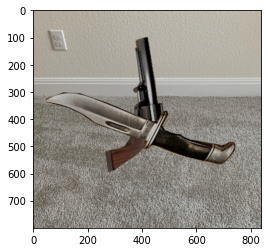

Segmentation Output


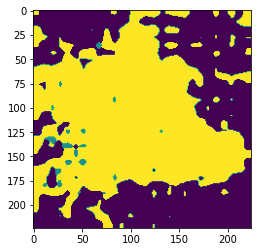

In [ ]:
semanticseg.predict('/content/gdrive/MyDrive/DEEPLOBE/data/Images/101.png')

In [ ]:

video_capture = cv2.VideoCapture(r"/content/gdrive/My Drive/outPut_1/VID_20200508_170355.mp4")
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
frame_width = int(video_capture.get(3))
frame_height = int(video_capture.get(4))
#print('width: ',frame_width, 'height: ',frame_height)
colors = torch.as_tensor([i for i in range(classes)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")
colors = np.array(list(class_dict.keys()),dtype='uint8')
# Define the codec and create VideoWriter object.The output is stored in 'output.avi' file.
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
out = cv2.VideoWriter('/content/gdrive/My Drive/outPut_1/final11.avi',fourcc, 30, (120,120),True)
model = model.to(device)
a = 0
while True:
    a = a+1
    #print('frame number', a)
    ret, frame = video_capture.read()
    if ret == False:
      break 
    rgb_frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2RGB)
    img = Image.fromarray(rgb_frame)
    input_size = img.size
    img = T.Resize(128)(img)
    img = T.CenterCrop(120)(img)
    img = T.ToTensor()(img)
    img = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)    
    frames = torch.tensor(img,dtype=torch.float).cuda()
    output = model(frames.unsqueeze(0))['out'][0]
    output_predictions = output.argmax(0)
    r = Image.fromarray(output_predictions.byte().cpu().numpy())#.resize(input_size)
    r.putpalette(colors)
    out_frame = cv2.cvtColor(np.array(r.convert('RGB')),cv2.COLOR_RGB2BGR)
    out.write(out_frame)
out.release()
video_capture.release()